<a href="https://colab.research.google.com/github/derrylnouva/projects/blob/main/07_milestone_project_1_food_vision_big_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f81a1e56-9f13-9d6a-1270-005fd824d476)


In [ ]:
# Download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-12 11:40:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-12 11:40:48 (99.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Download data from TensorFlow Datasets

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete0NXN4J/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete0NXN4J/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the data

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from food101 (tensor form): {label}
  class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from food101 (tensor form): 56
  class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor from TFDS's food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf 
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

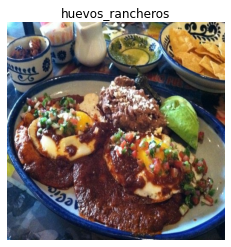

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Creating preprocessing functions for our data

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'unit8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & Prepare Datasets

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data_bp = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data_bp

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating modelling callbacks

In [ ]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience=3)

In [ ]:
# Setup reduce_lr
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## Setup mixed precision training

In [ ]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create the base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

# Create function model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, output)

# Compile the model
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model_1.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

## Fit the feature extraction model

In [ ]:
history_101_food_classes_efficientnetb4 = model_1.fit(train_data,
                                                      epochs=5,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data_bp,
                                                      validation_steps=int(0.15 * len(test_data_bp)),
                                                      callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                             experiment_name="efficientnetb4_101_food_classes"),
                                                                 model_checkpoint]) 

Saving TensorBoard log files to: training_logs/efficientnetb4_101_food_classes/20220812-115235
Epoch 1/5
2368/2368 [==============================] - 234s 90ms/step - loss: 3.0878 - accuracy: 0.3764 - val_loss: 2.1243 - val_accuracy: 0.5580
Epoch 2/5
2368/2368 [==============================] - 215s 90ms/step - loss: 2.0399 - accuracy: 0.5457 - val_loss: 1.6763 - val_accuracy: 0.6096
Epoch 3/5
2368/2368 [==============================] - 218s 91ms/step - loss: 1.7520 - accuracy: 0.5871 - val_loss: 1.4971 - val_accuracy: 0.6377
Epoch 4/5
2368/2368 [==============================] - 215s 90ms/step - loss: 1.6060 - accuracy: 0.6108 - val_loss: 1.3985 - val_accuracy: 0.6512
Epoch 5/5
2368/2368 [==============================] - 215s 90ms/step - loss: 1.5114 - accuracy: 0.6280 - val_loss: 1.3329 - val_accuracy: 0.6623


In [ ]:
feature_extraction_results = model_1.evaluate(test_data_bp)

790/790 [==============================] - 51s 65ms/step - loss: 1.3455 - accuracy: 0.6620


In [ ]:
for layer in model_1.layers[1].layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

In [ ]:
model_1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-08-12 12:14:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  --.-KB/s    in 0.1s    

2022-08-12 12:14:34 (169 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
gs_model = tf.keras.models.load_model('/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision')

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
gs_model_feature_extraction_results = gs_model.evaluate(test_data_bp)

790/790 [==============================] - 54s 65ms/step - loss: 1.0881 - accuracy: 0.7065


In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
gs_model.trainable = True

In [ ]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE
gs_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics =["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE
history_fine_tune_big_dog = gs_model.fit(train_data,
                                         epochs= 4,
                                         steps_per_epoch= len(train_data),
                                         validation_data = test_data_bp,
                                         validation_steps = int(0.15*len(test_data_bp)),
                                         callbacks = [create_tensorboard_callback('training_logs', 'food_101_big_dog_fine_tune_100'),
                                                      model_checkpoint,
                                                      earlystopping_callback])

Saving TensorBoard log files to: training_logs/food_101_big_dog_fine_tune_100/20220812-121616
Epoch 1/4
2368/2368 [==============================] - 406s 164ms/step - loss: 0.9207 - accuracy: 0.7529 - val_loss: 0.7774 - val_accuracy: 0.7834
Epoch 2/4
2368/2368 [==============================] - 346s 145ms/step - loss: 0.5649 - accuracy: 0.8452 - val_loss: 0.7958 - val_accuracy: 0.7828
Epoch 3/4
2368/2368 [==============================] - 347s 146ms/step - loss: 0.3129 - accuracy: 0.9127 - val_loss: 0.9437 - val_accuracy: 0.7688
Epoch 4/4
2368/2368 [==============================] - 342s 144ms/step - loss: 0.1645 - accuracy: 0.9510 - val_loss: 0.9902 - val_accuracy: 0.7797


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
gs_model.save('/content/drive/MyDrive/model/food_101_big_dog_template_model_fine_tune_100')

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
gs_model_fine_tune_100_results = gs_model.evaluate(test_data_bp)

790/790 [==============================] - 53s 66ms/step - loss: 1.0186 - accuracy: 0.7755


In [ ]:
gs_model_1 = tf.keras.models.load_model('/content/drive/MyDrive/model/food_101_big_dog_template_model_fine_tune_100')

In [ ]:
saved_gs_model_fine_tune_100_results = gs_model_1.evaluate(test_data_bp)

790/790 [==============================] - 58s 69ms/step - loss: 1.0186 - accuracy: 0.7755


In [ ]:
tf.experimental.numpy.isclose(gs_model_fine_tune_100_results, saved_gs_model_fine_tune_100_results)

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True,  True])>

In [ ]:
pred_probs = gs_model_1.predict(test_data_bp, verbose=1)
pred_probs

790/790 [==============================] - 66s 80ms/step


array([[3.7269601e-05, 5.3659899e-10, 5.5363247e-10, ..., 1.0167544e-06,
        1.3413288e-08, 1.0722914e-03],
       [9.0490584e-09, 1.0595358e-11, 2.1493398e-09, ..., 2.7756106e-10,
        1.3748477e-06, 2.8235671e-13],
       [2.4655533e-09, 4.2600941e-09, 6.7262917e-11, ..., 1.5728654e-11,
        4.3362885e-08, 1.1026637e-09],
       ...,
       [5.1870744e-04, 9.8581643e-07, 6.2493383e-12, ..., 2.8568516e-09,
        1.7301617e-06, 1.1823509e-05],
       [6.9644710e-17, 1.4788238e-22, 2.2166383e-19, ..., 1.6081463e-23,
        1.5409698e-21, 1.2001085e-21],
       [1.3907619e-07, 5.7732319e-10, 5.0658495e-09, ..., 1.1398898e-05,
        4.7318292e-08, 2.6281282e-09]], dtype=float32)

In [ ]:
# Get prediction classes
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([29, 81, 91, 53, 97, 36, 10, 31,  3,  0])

In [ ]:
# Get labels from the test data using `unbatch()` method
y_labels = []
for images, labels in test_data_bp.unbatch():
  y_labels.append(labels.numpy())

In [ ]:
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7754851485148515

In [ ]:
# 1. Find the precision, recall and f1 scores for each class 
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60       250
           1       0.84      0.66      0.74       250
           2       0.85      0.86      0.85       250
           3       0.77      0.82      0.79       250
           4       0.60      0.83      0.69       250
           5       0.65      0.70      0.67       250
           6       0.83      0.89      0.86       250
           7       0.90      0.90      0.90       250
           8       0.68      0.54      0.60       250
           9       0.79      0.66      0.72       250
          10       0.80      0.66      0.72       250
          11       0.70      0.90      0.79       250
          12       0.89      0.82      0.85       250
          13       0.79      0.77      0.78       250
          14       0.73      0.80      0.76       250
          15       0.65      0.61      0.63       250
          16       0.70      0.63      0.67       250
          17       0.80    

In [ ]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.6018099547511312,
  'precision': 0.6927083333333334,
  'recall': 0.532,
  'support': 250},
 '1': {'f1-score': 0.7382550335570469,
  'precision': 0.8375634517766497,
  'recall': 0.66,
  'support': 250},
 '10': {'f1-score': 0.7221006564551423,
  'precision': 0.7971014492753623,
  'recall': 0.66,
  'support': 250},
 '100': {'f1-score': 0.8438818565400844,
  'precision': 0.8928571428571429,
  'recall': 0.8,
  'support': 250},
 '11': {'f1-score': 0.788091068301226,
  'precision': 0.7009345794392523,
  'recall': 0.9,
  'support': 250},
 '12': {'f1-score': 0.8547717842323651,
  'precision': 0.8879310344827587,
  'recall': 0.824,
  'support': 250},
 '13': {'f1-score': 0.7813765182186235,
  'precision': 0.7909836065573771,
  'recall': 0.772,
  'support': 250},
 '14': {'f1-score': 0.7633587786259542,
  'precision': 0.7299270072992701,
  'recall': 0.8,
  'support': 250},
 '15': {'f1-score': 0.6283367556468172,
  'precision': 0.6455696202531646,
  'recall': 0.612,
  'support':

In [ ]:
class_f1_score = {}
# Loop through classification report item
for k,v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    # Append class names and f1_score to a new dictionary
    class_f1_score[class_names[int(k)]] = v['f1-score']

class_f1_score

{'apple_pie': 0.6018099547511312,
 'baby_back_ribs': 0.7382550335570469,
 'baklava': 0.8508946322067595,
 'beef_carpaccio': 0.7945736434108526,
 'beef_tartare': 0.6934673366834171,
 'beet_salad': 0.6743295019157088,
 'beignets': 0.8588007736943907,
 'bibimbap': 0.8977955911823646,
 'bread_pudding': 0.601336302895323,
 'breakfast_burrito': 0.7177242888402625,
 'bruschetta': 0.7221006564551423,
 'caesar_salad': 0.788091068301226,
 'cannoli': 0.8547717842323651,
 'caprese_salad': 0.7813765182186235,
 'carrot_cake': 0.7633587786259542,
 'ceviche': 0.6283367556468172,
 'cheese_plate': 0.8226120857699805,
 'cheesecake': 0.6652631578947369,
 'chicken_curry': 0.6347517730496454,
 'chicken_quesadilla': 0.7804878048780487,
 'chicken_wings': 0.8515625000000001,
 'chocolate_cake': 0.6305882352941177,
 'chocolate_mousse': 0.5845511482254697,
 'churros': 0.8771929824561403,
 'clam_chowder': 0.818348623853211,
 'club_sandwich': 0.8482328482328482,
 'crab_cakes': 0.6227347611202636,
 'creme_brulee': 0

In [ ]:
# Convert f1-score to a dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_name': list(class_f1_score.keys()),
                          'f1_score': list(class_f1_score.values())}).sort_values('f1_score', ascending = False)

f1_scores

,class_name,f1_score
33,edamame,0.991968
63,macarons,0.944444
64,miso_soup,0.909091
88,seaweed_salad,0.907631
54,hot_and_sour_soup,0.907216
...,...,...
22,chocolate_mousse,0.584551
37,filet_mignon,0.579909
77,pork_chop,0.555354
39,foie_gras,0.528000


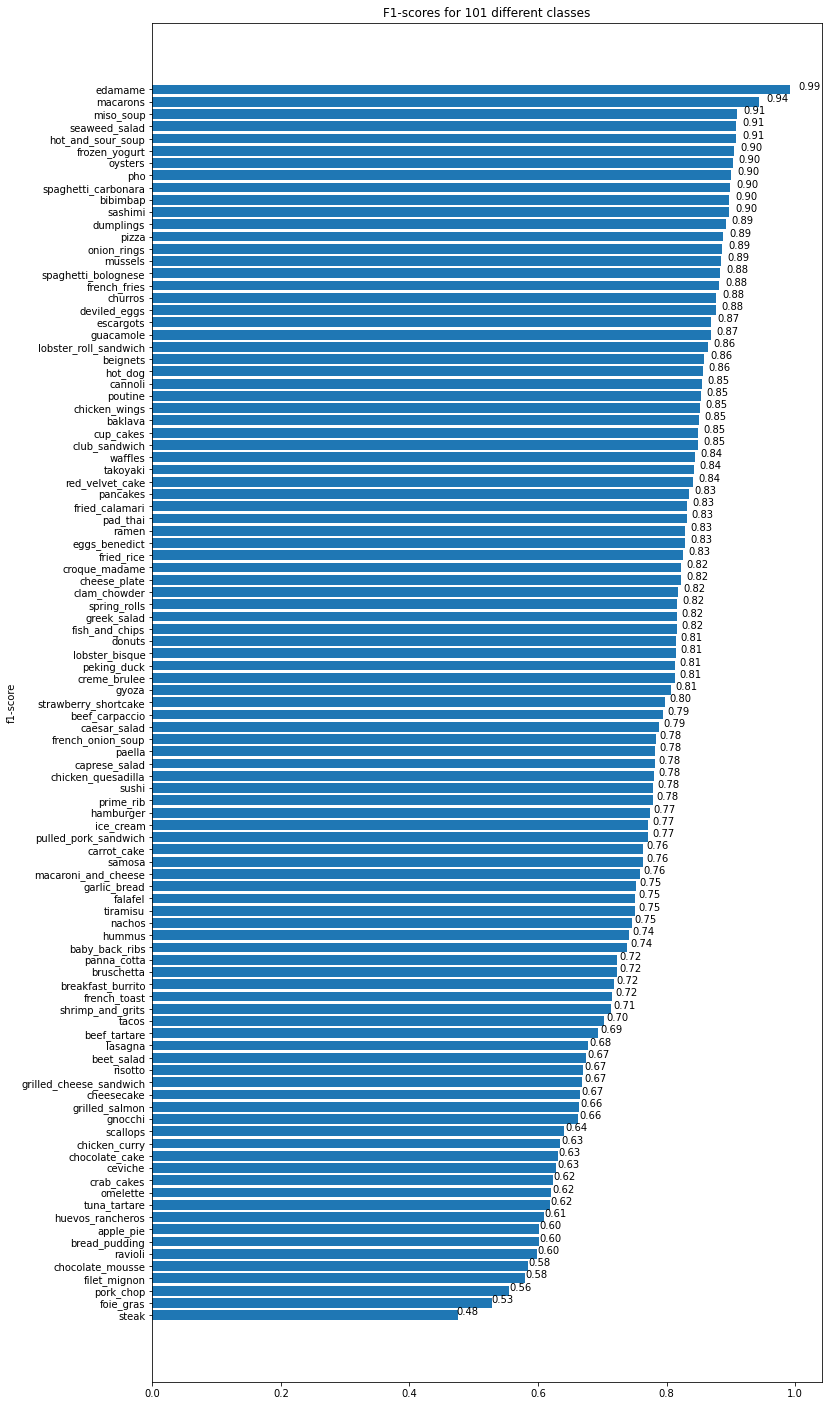

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1_score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_ylabel('f1-score')
ax.set_title('F1-scores for 101 different classes')
ax.invert_yaxis();

def autolabel(rects): 
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
    
autolabel(scores)

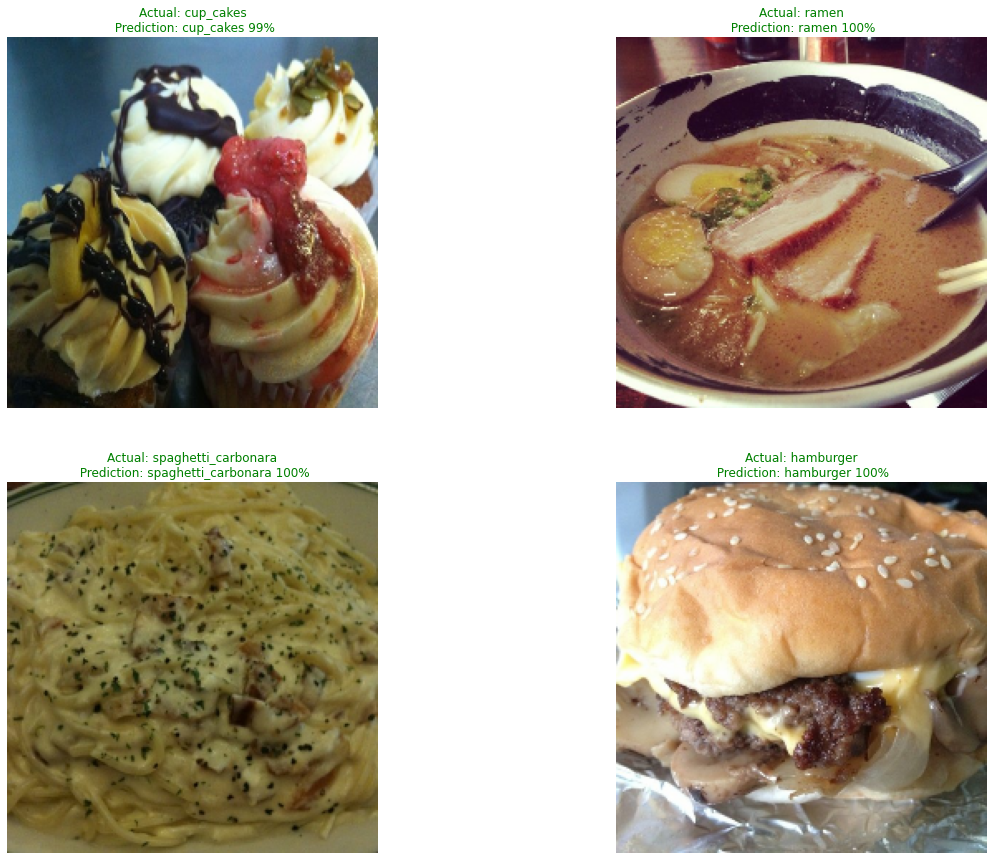

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
num_img = 4
for i in range(num_img):
  plt.subplot(num_img/2, num_img/2, i+1)
  for image, label in test_data.take(i+1):
    image = tf.image.resize(image, [224, 224])
    img = tf.cast(image, dtype=tf.float32)
    img = tf.expand_dims(img, axis=0)
    pred_prob = gs_model_1.predict(img)
    pred = tf.argmax(pred_prob, axis=1)[0]

    if pred == label:
      color = 'green'
    else:
      color = 'red'

    plt.imshow(image/255.)
    plt.title(f"Actual: {class_names[label]}\n Prediction: {class_names[pred]} {tf.reduce_max(pred_prob)*100:2.0f}%", color = color)
    plt.axis(False) 

## Finding the most wrong predictions

In [ ]:
pred_probs.max(axis=1)

array([0.99021566, 0.9979517 , 0.99946314, ..., 0.6395547 , 1.        ,
       0.85270834], dtype=float32)

In [ ]:
# Sorting all wrong prediction in on DataFrame
pred_df = pd.DataFrame({
    "img_num": [k for k in range(len(y_labels))],
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})
pred_df["correct"] = pred_df["y_true_classname"] == pred_df["y_pred_classname"]
pred_df

,img_num,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,correct
0,0,29,29,0.990216,cup_cakes,cup_cakes,True
1,1,81,81,0.997952,ramen,ramen,True
2,2,91,91,0.999463,spaghetti_carbonara,spaghetti_carbonara,True
3,3,53,53,0.998171,hamburger,hamburger,True
4,4,97,97,0.998218,takoyaki,takoyaki,True
...,...,...,...,...,...,...,...
25245,25245,38,38,1.000000,fish_and_chips,fish_and_chips,True
25246,25246,86,86,0.999974,sashimi,sashimi,True
25247,25247,76,46,0.639555,pizza,garlic_bread,False
25248,25248,31,31,1.000000,donuts,donuts,True


In [ ]:
wrong_pred_df = pred_df[pred_df["correct"]==False].sort_values("pred_conf", ascending=False).reset_index().drop("index", axis=1)
wrong_pred_df

,img_num,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,correct
0,9735,87,30,1.000000,scallops,deviled_eggs,False
1,15437,56,66,1.000000,huevos_rancheros,nachos,False
2,13884,46,10,1.000000,garlic_bread,bruschetta,False
3,11647,44,67,0.999997,fried_rice,omelette,False
4,1113,72,67,0.999997,pancakes,omelette,False
...,...,...,...,...,...,...,...
5664,24796,77,97,0.174254,pork_chop,takoyaki,False
5665,24905,0,8,0.173935,apple_pie,bread_pudding,False
5666,13828,59,61,0.168630,lasagna,lobster_roll_sandwich,False
5667,16200,81,50,0.164298,ramen,grilled_salmon,False


In [ ]:
df_worst_6 = wrong_pred_df.sort_values('img_num')[:6].reset_index().drop('index', axis = 1)
df_worst_6

,img_num,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,correct
0,5,97,36,0.519787,takoyaki,falafel,False
1,9,100,0,0.435743,waffles,apple_pie,False
2,16,84,70,0.946800,risotto,pad_thai,False
3,27,1,77,0.891608,baby_back_ribs,pork_chop,False
4,29,42,4,0.475895,french_toast,beef_tartare,False
5,30,6,85,0.962285,beignets,samosa,False


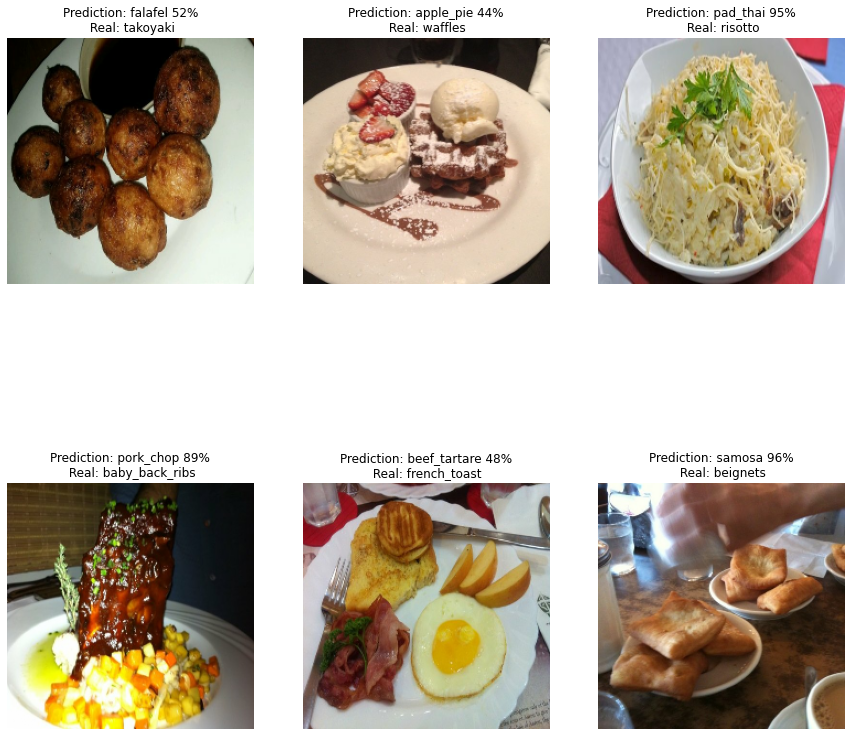

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
num_img = len(df_worst_6)
for index, row in df_worst_6.iterrows():
  sample = test_data.take(int(row.img_num)+ 1)
  n = len(sample)
  plt.subplot(2,3, index+1)
  for image, label in sample:
    n=n-1
    if n==0:
      img = image
      img = tf.image.resize(img,[224,224])
      plt.title(f'Prediction: {row.y_pred_classname} {row.pred_conf*100:2.0f}%\n Real: {row.y_true_classname}')
      plt.imshow(img/255., cmap = plt.cm.binary)
      plt.axis(False)